In [1]:
import torch
import numpy as np

/Users/stalkr/miniconda3/envs/thesis-dev/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import prototorch as pt

In [3]:
from prototorch.models import GMLVQ, VisGMLVQ2D

In [4]:
import pytorch_lightning as pl

In [5]:
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.utilities.warnings import PossibleUserWarning
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

In [6]:
import matplotlib.pyplot as plt

In [7]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [8]:
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=PossibleUserWarning)

In [9]:
# Reproducibility
seed_everything(seed=4)

Global seed set to 4


4

In [10]:

from torchvision import transforms

In [11]:
# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x : x.view(x.shape[0], -1)),
])

In [12]:

# Dataset
train_ds = MNIST('.', download=True, transform=transform) #pt.datasets.Iris()

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=64, num_workers=4)

In [13]:
xdata, xlabel = train_ds[120]
xdata.shape, xlabel

(torch.Size([1, 784]), 2)

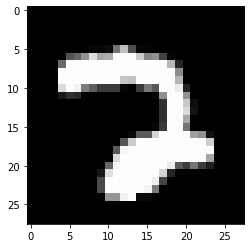

In [14]:
show_tensor_images(xdata.view(1,1,28,28), num_images=1, size=(1, 28, 28))

In [15]:
# Hyperparameters for the GMLVQ layer
hparams = dict(
    input_dim=28*28,
    latent_dim=28*28,
    distribution={
        "num_classes": 10,
        "per_class": 3
    },
    proto_lr=0.01,
    bb_lr=0.01,
)

In [16]:

# Initialize the model
model = GMLVQ(
    hparams,
    optimizer=torch.optim.Adam,
    prototypes_initializer=pt.initializers.SMCI(train_ds),
    lr_scheduler=ExponentialLR,
    lr_scheduler_kwargs=dict(gamma=0.99, verbose=False),
)

In [17]:
initial_prototypes = model.prototypes.detach()
initial_prototypes.shape

torch.Size([30, 1, 784])

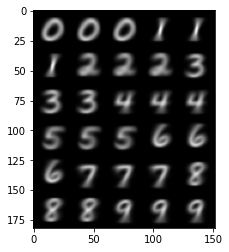

In [18]:
show_tensor_images(initial_prototypes.view(initial_prototypes.shape[0],1,28,28), num_images=30)

In [19]:
initial_prototype_labels = model.prototype_labels.detach()
initial_prototype_labels

tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7,
        8, 8, 8, 9, 9, 9])

In [23]:
cs.generate(3).shape, model.prototypes.shape
# model.prototypes = torch.cat((model.prototypes, cs.generate(3)), 0)
altered_params = {"components": torch.cat((model.prototypes, cs.generate(3)), 0),
                 "labels": torch.cat((model.prototype_labels, torch.zeros(3)+10)),
                 }
altered_params
# model.proto_layer.save_hyperparameters(altered_params)
# model.proto_layer.components = torch.cat((model.prototypes, cs.generate(3)), 0)

{'components': tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         ...,
 
         [[ 0.4448,  0.0551,  0.6501,  ...,  0.2805,  0.1500,  0.0509]],
 
         [[ 0.2569,  0.9806,  0.5696,  ...,  0.8280,  0.6454,  0.7230]],
 
         [[ 0.1991,  0.3588,  0.7148,  ...,  0.7556,  0.1087,  0.0609]]]),
 'labels': tensor([ 0.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,
          4.,  5.,  5.,  5.,  6.,  6.,  6.,  7.,  7.,  7.,  8.,  8.,  8.,  9.,
          9.,  9., 10., 10., 10.])}

In [25]:
model.add_prototypes(components_initializer=pt.initializers.UCI((1, 784)), distribution={
        "num_classes": 1,
        "per_class": 3
    },)

In [26]:
altered_prototypes = model.prototypes.detach()
altered_prototypes.shape

torch.Size([33, 1, 784])

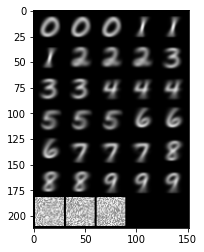

In [29]:
show_tensor_images(altered_prototypes.view(altered_prototypes.shape[0],1,28,28), num_images=33)

In [30]:
# # Compute intermediate input and output sizes
model.example_input_array = torch.zeros(784, 784)

In [31]:


# %matplotlib inline
# Callbacks
# vis = show_tensor_images(model.prototypes, num_images=10) #VisGMLVQ2D(data=train_ds)

In [32]:

# Setup trainer
trainer = pl.Trainer(#.from_argparse_args(
    # args,
    accelerator="cpu",
    devices=1,
    # callbacks=[
    #     vis,
    # ],
    max_epochs=50,
    log_every_n_steps=50,
    detect_anomaly=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:

# Training loop
trainer.fit(model, train_loader)

# validating learnt model
# print ("Prototypes :")
# print (model.prototypes)
# print ("Prototype labels :")
# print (model.prototype_labels)
print ("Omega matrix :")
print (model._omega.detach())

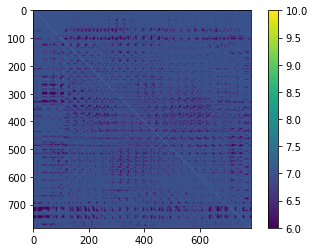

In [57]:
plt.imshow(torch.round((torch.sigmoid(new_omega)*9)/torch.max(torch.sigmoid(new_omega))) + 1)
plt.colorbar(orientation='vertical')